In [37]:
# ======================================================================
# Sentiment Analysis - Logistic Regression Algorithm
# ======================================================================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Example: Adjust the path below to your actual file
file_path = 'path-to-file'
df = pd.read_csv(file_path, encoding='latin1')

In [28]:
df.head()

,reviewer_id,store_location,latitude,longitude,date,month,year,title,review,review-label
0,0.0,US,37.090240,-95.712891,2023,6,2015 00:00:00,Great help with lost order,I had an order that was lost in transit. When ...,5
1,1.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,I ordered the wrong size tee and hadï¿½ï¿½ï¿½,I ordered the wrong size tee and had difficult...,5
2,2.0,US,37.090240,-95.712891,2023,6,2017 00:00:00,These guys offer the best customerï¿½ï¿½ï¿½,These guys offer the best customer service in ...,5
3,3.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,Good Stuff,Looked for an obscure phrase on a shirt. Teepu...,5
4,4.0,CA,56.130366,-106.346771,2023,6,2023 00:00:00,My order arrived in a good timelyï¿½ï¿½ï¿½,My order arrived in a good timely fashion & th...,4


In [29]:
def get_sentiment(label):
    if label <= 2:
        return "Negative"
    elif label == 3:
        return "Neutral"
    else:
        return "Positive"

df['sentiment'] = df['review-label'].apply(get_sentiment)

print(df['sentiment'].value_counts())

sentiment
Positive    232075
Negative     29470
Neutral      16555
Name: count, dtype: int64


In [30]:
# Fill missing values to avoid errors
df['title'] = df['title'].fillna('')
df['review'] = df['review'].fillna('')

# Combine them
df['text'] = df['title'] + " " + df['review']

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=20000, stop_words='english')

# Learn vocabulary and transform text
X_text = tfidf.fit_transform(df['text'])

print("TF-IDF feature matrix shape:", X_text.shape)

TF-IDF feature matrix shape: (278100, 20000)


In [31]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_location = encoder.fit_transform(df[['store_location']])

print("Location feature matrix shape:", X_location.shape)

# Combine text + location
X = hstack([X_text, X_location])

Location feature matrix shape: (278100, 141)


In [32]:
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 222480
Testing samples: 55620


In [33]:
model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced'
)

model.fit(X_train, y_train)
print("✅ Model training complete")

✅ Model training complete


📊 Classification Report:
              precision    recall  f1-score   support

    Negative       0.65      0.74      0.70      5894
     Neutral       0.29      0.61      0.39      3311
    Positive       0.99      0.89      0.94     46415

    accuracy                           0.86     55620
   macro avg       0.64      0.75      0.67     55620
weighted avg       0.91      0.86      0.88     55620



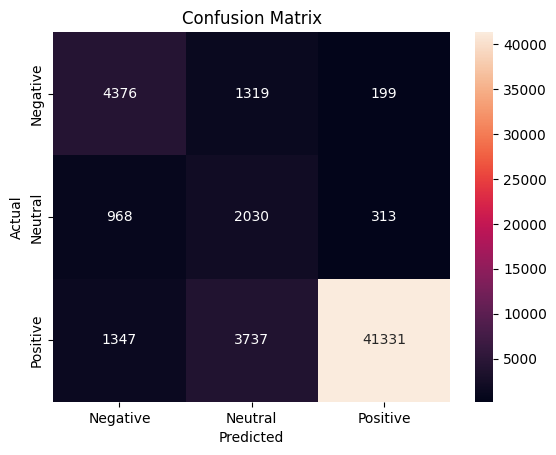

In [34]:
y_pred = model.predict(X_test)

# Classification report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred, labels=["Negative", "Neutral", "Positive"])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [36]:
new_reviews = [
    "This product is amazing, I love it!",   # Positive
    "It's okay, nothing special",           # Neutral
    "Very bad quality, disappointed"        # Negative
]

# Transform using the same TF-IDF vectorizer & encoder
new_text_features = tfidf.transform(new_reviews)

new_location_df = pd.DataFrame({"store_location": ["US", "US", "US"]})
new_location_features = encoder.transform(new_location_df)

new_X = hstack([new_text_features, new_location_features])

predictions = model.predict(new_X)
for review, sentiment in zip(new_reviews, predictions):
    print(f"📝 Review: {review}\n→ Predicted Sentiment: {sentiment}\n")

📝 Review: This product is amazing, I love it!
→ Predicted Sentiment: Positive

📝 Review: It's okay, nothing special
→ Predicted Sentiment: Neutral

📝 Review: Very bad quality, disappointed
→ Predicted Sentiment: Negative

